# Permutation Equivariant Neural Networks

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, ReLU, Dense, Flatten, Input, Lambda
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Data Preparation

This section contains the code for loading the data and preprocessing it into the desired format. For example, it transforms the 15-length rows in `x_train` into $5 \times 3$ matrices.

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving xtest-2.csv to xtest-2.csv
Saving xtrain-2.csv to xtrain-2.csv
Saving ytest-2.csv to ytest-2.csv
Saving ytrain-2.csv to ytrain-2.csv


In [ ]:
import io

xtrain = pd.read_csv(io.BytesIO(uploaded['xtrain-2.csv']))
ytrain = pd.read_csv(io.BytesIO(uploaded['ytrain-2.csv']))
xtest = pd.read_csv(io.BytesIO(uploaded['xtest-2.csv']))
ytest = pd.read_csv(io.BytesIO(uploaded['ytest-2.csv']))

print("xtrain head:")
print(xtrain.head())

xtrain head:
   Unnamed: 0         0         1         2         3         4         5  \
0           0  0.978738  2.240893  1.867558 -0.977278  0.950088 -0.151357   
1           1 -0.549746 -1.402873  1.582752 -1.045147  0.257594 -1.959395   
2           2 -2.136196  1.640271 -1.793436 -0.841747  0.502881 -1.245288   
3           3  0.096497 -1.863493 -0.277388 -0.354759 -0.082741 -0.627001   
4           4  0.318870  1.039999 -1.051482  0.286104  0.727236 -1.009721   

          6         7         8         9        10        11        12  \
0 -0.103219  0.410599  0.144044  1.454274  0.761038  0.121675  0.443863   
1 -1.507808 -0.315292  0.858179  0.071343 -2.292309 -1.415552  0.885829   
2 -1.057952 -0.909008  0.551454  2.292208  0.041539 -1.117925  0.539058   
3 -0.043818 -0.477218 -1.313865  0.884622  0.881318  1.709573  0.050034   
4  0.253365  0.768269  1.237225 -1.645606  1.217134 -0.422298 -1.460323   

         13        14  
0  0.333674  1.494079  
1  0.631902  0.040260  
2

In [ ]:
print("xtrain shape:", xtrain.shape)
print("xtest shape:", xtest.shape)

xtrain shape: (200000, 16)
xtest shape: (200000, 16)


In [ ]:
xtrain = xtrain.drop(xtrain.columns[0], axis=1)
ytrain = ytrain.drop(ytrain.columns[0], axis=1)
xtest = xtest.drop(xtest.columns[0], axis=1)
ytest = ytest.drop(ytest.columns[0], axis=1)

print("xtrain head:")
print(xtrain.head())

xtrain head:
          0         1         2         3         4         5         6  \
0  0.978738  2.240893  1.867558 -0.977278  0.950088 -0.151357 -0.103219   
1 -0.549746 -1.402873  1.582752 -1.045147  0.257594 -1.959395 -1.507808   
2 -2.136196  1.640271 -1.793436 -0.841747  0.502881 -1.245288 -1.057952   
3  0.096497 -1.863493 -0.277388 -0.354759 -0.082741 -0.627001 -0.043818   
4  0.318870  1.039999 -1.051482  0.286104  0.727236 -1.009721  0.253365   

          7         8         9        10        11        12        13  \
0  0.410599  0.144044  1.454274  0.761038  0.121675  0.443863  0.333674   
1 -0.315292  0.858179  0.071343 -2.292309 -1.415552  0.885829  0.631902   
2 -0.909008  0.551454  2.292208  0.041539 -1.117925  0.539058 -0.596160   
3 -0.477218 -1.313865  0.884622  0.881318  1.709573  0.050034 -0.404677   
4  0.768269  1.237225 -1.645606  1.217134 -0.422298 -1.460323  0.703661   

         14  
0  1.494079  
1  0.040260  
2 -0.019130  
3 -0.545360  
4  1.115444  


In [ ]:
# Reshape xtrain and xtest
m, d = 5, 3
xtrain = xtrain.values.reshape(-1, m, d)
xtest = xtest.values.reshape(-1, m, d)

In [ ]:
# Change data type since neural networks generally prefer using float32 over int64.
xtrain = xtrain.astype(np.float32)
xtest = xtest.astype(np.float32)
ytrain = ytrain.astype(np.float32)
ytest = ytest.astype(np.float32)

# Model

# **Permutation-Equivariant Model in Neural Networks**
Based on the provided background information, we propose the following model:
### Model Structure:
Here is a detailed breakdown of the model architecture, specifying the behavior of each component in different scenarios. Note that the design of this model architecture follows the model definition in the slides given.

| **Component**           | **Description** | **Output Shape** |
|-------------------------|----------------|------------------|
| **Input Layer**        | Accepts input data of shape $(m, d)$, where $ m $ is the number of elements, and $ d $ is the feature dimension. | $(m, d)$ |
| **EquivariantLayer (for first $ L-1 $ layers)** | Applies a permutation-equivariant affine transformation|$(m, w)$ |
| **ReLU Activation (for first $ L-1 $ layers)** | Applies ReLU activation after each of the first $ L-1 $ equivariant layers. | $(m, w)$ |
| **EquivariantLayer (final layer)** | Same transformation as previous layers, but output dimension is 1 (i.e., $ w = 1 $). No activation function applied. | $(m, 1)$ |
| **Reshape Layer**       | Reshapes the final output to match the target shape. | $(m, )$ |

### Additional Details:

1. **EquivariantLayer**:
- In each **EquivariantLayer**, there are three learnable parameters a, b, and c helping to compute the transformation:
$$
f(x) = a \cdot x + b \cdot \left( \frac{1}{m} \sum_{i=1}^{m} x_i \right) + c
$$

2. **Training**: The model is trained using the Adam optimizer with a learning rate of 1e-4 and epsilon of 1e-3. The loss function is Mean Squared Error (MSE).

3. **Evaluation**: The model is evaluated on the test set, and the test MSE is computed for each combination of $ (L, w) $.

---


### Expectation:
- **Training and Validation Loss**: The plots are expected to show a decrease in both training and validation loss over epochs. The validation loss and training loss should not differ a lot as well.
- **Test MSE**: For smaller values of $L$ and $w$, the model may underfit, resulting in a higher MSE. Increasing the number of layers ($L$) or the width ($w$) improves the model's capacity to learn complex patterns. However, for values of $L$ and $w$ that are too large, the model may overfit, resulting in a lower MSE. The optimal combination of $L$ and $w$ will vary in each specific situation.

In [ ]:
# Define permutation-equivariant affine transformation
class EquivariantLayer(layers.Layer):
    def __init__(self, output_dim):
        super(EquivariantLayer, self).__init__()
        self.output_dim = output_dim

    def build(self, input_shape):
        self.a = self.add_weight(shape=(input_shape[-1], self.output_dim),
                                initializer='glorot_uniform',
                                trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1], self.output_dim),
                                initializer='glorot_uniform',
                                trainable=True)
        self.c = self.add_weight(shape=(self.output_dim,),
                                initializer='zeros',
                                trainable=True)

    def call(self, inputs):
        # Compute the permutation-equivariant transformation
        mean_inputs = tf.reduce_mean(inputs, axis=1, keepdims=True)  # (batch_size, 1, d)
        term1 = tf.einsum('bmd,df->bmf', inputs, self.a)  # (batch_size, m, output_dim)
        term2 = tf.einsum('bmd,df->bmf', mean_inputs, self.b)  # (batch_size, m, output_dim)
        output = term1 + term2 + self.c  # (batch_size, m, output_dim)
        return output

In [ ]:
# Define the feedforward neural network
def create_equivariant_model(L, w, m, d):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(m, d)))

    # Add L-1 equivariant layers with ReLU activation
    for _ in range(L - 1):
        model.add(EquivariantLayer(output_dim=w))
        model.add(layers.ReLU())

    # Add the final equivariant layer (no activation)
    model.add(EquivariantLayer(output_dim=1))

    # Flatten the output to match the target shape (m,)
    model.add(layers.Reshape((m,)))

    return model

In [ ]:
# Train and evaluate the model
def train_model(L, w, xtrain, ytrain, xtest, ytest):
    model = create_equivariant_model(L, w, m, d)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-3),
                  loss='mse')

    history = model.fit(xtrain, ytrain,
                        validation_split=0.1,
                        batch_size=300,
                        epochs=100,
                        verbose=0)

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'L={L}, w={w}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Compute test MSE
    test_mse = model.evaluate(xtest, ytest, verbose=0)
    print(f'Test MSE for L={L}, w={w}: {test_mse}')

    return test_mse

Training model with L=5, w=2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


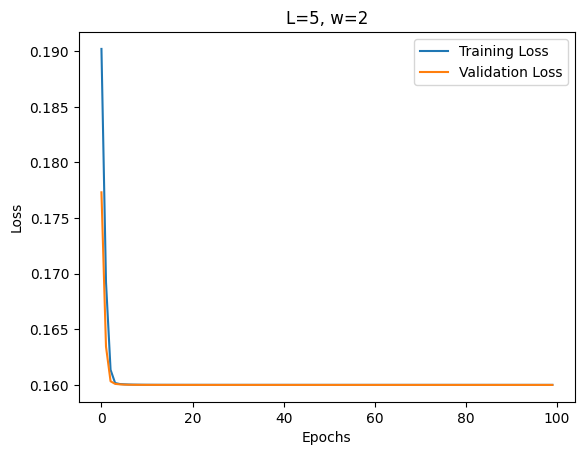

Test MSE for L=5, w=2: 0.16000069677829742
Training model with L=2, w=10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


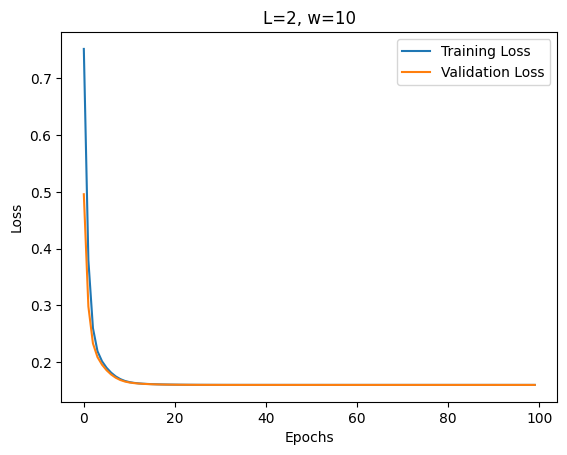

Test MSE for L=2, w=10: 0.16000208258628845
Training model with L=2, w=100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


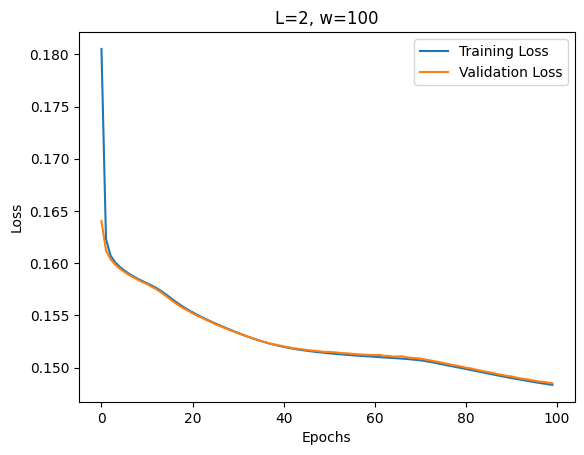

Test MSE for L=2, w=100: 0.14843307435512543
Training model with L=2, w=200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


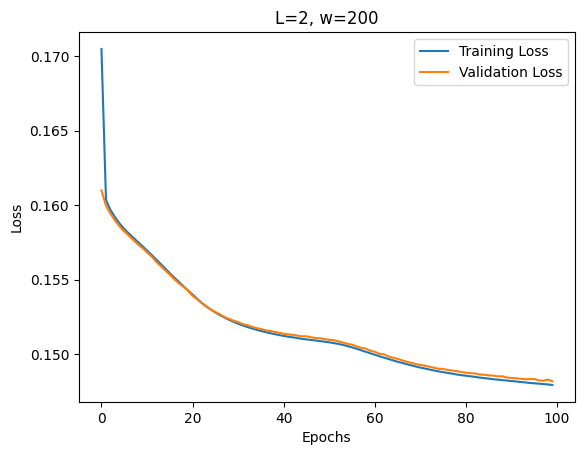

Test MSE for L=2, w=200: 0.14810781180858612
Training model with L=3, w=5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


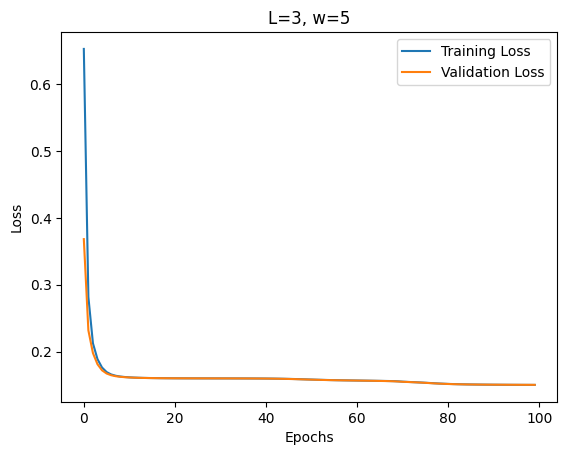

Test MSE for L=3, w=5: 0.15019124746322632
Training model with L=3, w=10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


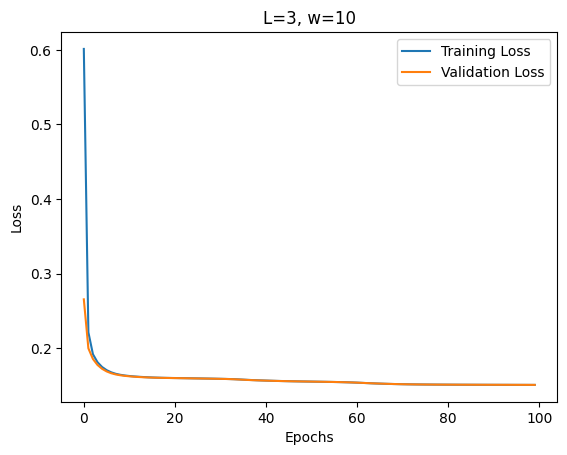

Test MSE for L=3, w=10: 0.15094368159770966
Training model with L=3, w=100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


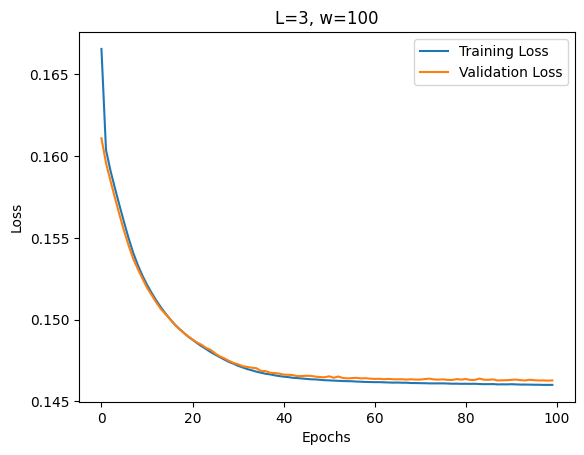

Test MSE for L=3, w=100: 0.14632222056388855
Training model with L=3, w=200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


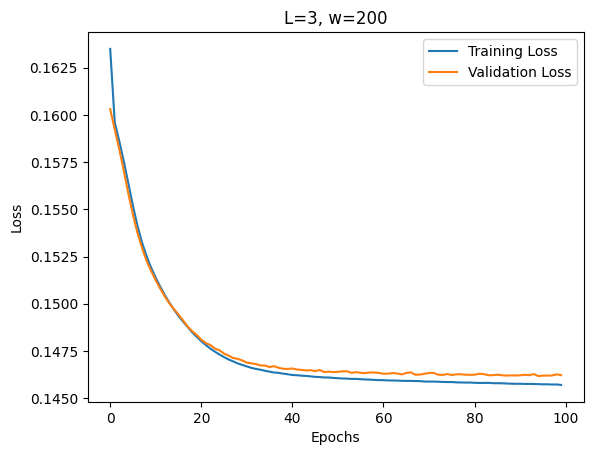

Test MSE for L=3, w=200: 0.14625075459480286
L=5, w=2: Test MSE = 0.16000069677829742
L=2, w=10: Test MSE = 0.16000208258628845
L=2, w=100: Test MSE = 0.14843307435512543
L=2, w=200: Test MSE = 0.14810781180858612
L=3, w=5: Test MSE = 0.15019124746322632
L=3, w=10: Test MSE = 0.15094368159770966
L=3, w=100: Test MSE = 0.14632222056388855
L=3, w=200: Test MSE = 0.14625075459480286


In [ ]:
# Train for different (L, w) combinations
combinations = [(5, 2), (2, 10), (2, 100), (2, 200), (3, 5), (3, 10), (3, 100), (3, 200)]
results = {}
for L, w in combinations:
    print(f'Training model with L={L}, w={w}')
    test_mse = train_model(L, w, xtrain, ytrain, xtest, ytest)
    results[(L, w)] = test_mse

# Print results
for (L, w), mse in results.items():
    print(f'L={L}, w={w}: Test MSE = {mse}')

The results above show the **Loss Curves** and **Test MSE** for different combinations (Configs in code) of $L$ (number of layers) and $w$ (width of layers).

---

### **Observations:**
The loss curves all slope downward, with the rate of decrease gradually slowing over time. with the validation loss remaining close to the training loss, as expected.

All test MSE values are very close, ranging from **0.1463** to **0.1600**. This suggests that the model's performance is fairly stable across different combinations. The combination with $L = 3$ and $w = 200$ yields the best performance, with a Test MSE of **0.146251**. Conversely, the combination with $L = 2$ and $w = 10$ performs the worst, with a Test MSE of **0.160003**. This is expected, as these two combinations represent the largest and smallest values of L and w, respectively. Hence, the overfitting problem has not yet appeared in the combinations we tested.

Notice that $L=5$ and $w=2$ is a special case, as its L is much larger than the others, while its w is much smaller. Its test MSE is slightly greater than the worst-case scenario.

In addition, there are some noticeable differences and insights. Increasing L or w improves performance (lowers test MSE). This is expected because wider layers (larger w) allow the model to learn more complex patterns, while deeper networks (larger L) may capture more hierarchical features.

---

### **Conclusion:**
The results demonstrate that the permutation-equivariant neural network performs well across a range of layer designs, with the best performance achieved for $L = 3$ and $w = 200$. The stability of the results highlights the robustness of the equivariant architecture, while the trends in Test MSE provide insights into the trade-offs between depth and width.